<img src="https://drive.google.com/uc?id=181S0KcAdGeAajZ1apcbOvoh3wvYuKtzd">
<b>Autores</b>:

*   Aldo von Wangenheim (aldo.vw@ufsc.br)
*   Rodrigo de Paula e Silva Ribeiro (ribeiro.rodrigo@posgrad.ufsc.br)


CERTIFIQUE-SE DE TER INCIADO O AMBIENTE EM MODO <b>GPU</b> ANTES DE REALIZAR OS PROCEDIMENTOS.<br>
NA TROCA DO AMBIENTE ELE <b><u>PERDE</u></b> TODOS OS DADOS BAIXADOS.

AO RE-EXECUTAR OS PROCEDIMENTOS (ex. diminuir o batch size), <br>REINICIE O AMBIENTE PARA LIBERAR O CACHE DO PYTORCH (reiniciar não perde os dados da sessão).<br>(alt+m ou pelo menu "Ambiente de Execução")

EXECUTE UTILIZANDO RUN ALL ou CTRL+F9

<a href="https://colab.research.google.com/github.com/awangenh/vision/blob/master/jupyter/14.5.YOLO.Detec%C3%A7%C3%A3o.ipynb"><img align="left"  src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>&nbsp; &nbsp;<a href=""><img align="left" src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/License-CC-BY-ND-4.0-orange.png" alt="Creative Commons 4.0 License" title="Creative Commons 4.0 License"></a>&nbsp; &nbsp; <a href=""><img align="left" src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/Jupyter-Notebook-v.1.0-blue.png" alt="Jupyter Version" title="Jupyter Version"></a>&nbsp; &nbsp;<a href=""><img align="left"  src="https://img.shields.io/badge/python-3.10-greeng" alt="Python Version" title="Python Version"></a>

In [1]:
!nvidia-smi
!nvcc --version

Tue May 28 02:05:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Definir a pasta base atual.

In [ ]:
try:
    import google.colab
    _ON_COLAB = True
except:
    _ON_COLAB = False

print('Running on Google Colab = ', _ON_COLAB)
import os
# Definir o caminho base
if _ON_COLAB:
    BASE_PATH = "/content"
else:
    BASE_PATH = "/lapix" # trocar para o base path do seu computador se estiver rodando localmente, deixar /lapix se estiver rodando nos conteiners lapix

os.chdir(BASE_PATH) # garantir que está executando no caminho base definido

/content


# O que é YOLO?
YOLO (“You Only Look Once”), é uma série de detectores de objetos de processamento rápido que vem sendo desenvolvida por diversos autores. Ao contrário dos detectores tradicionais que utilizam áreas de interesse para propor regiões (ROI) que podem conter um objeto na imagem (conhecidos como detectores de 2-estágios), a arquitetura YOLO divide a imagem em grids e vasculha a imagem como um todo (detector de um único estágio).

Neste notebook didático, é utilizado a versão 10 desta arquitetura.<br>
Algumas notas sobre a versão 10:<br>
* Em uma abordagem nova, foi removido a NMS e trocado por um head 1x1 para reduzir o peso computacional e melhorar a latência.
* Assim como a versão 9, a versão 10 é pré-treinada no [COCO Dataset](https://cocodataset.org/#home) e não no ImageNet.
* Diferente de outras versões anteriores (9, 7, 6, 4), a versão 10 é construida sobre o Yolo V8, no framework Ultralytics de modo que pode ser executada como módulo cli ou pela lib ultralytics, este notebook utiliza chamada de módulo cli.
* Foram realizadas diversas melhorias na arquitetura em relação a inferência, o mais notável é o consumo de VRAM, em comparação com Yolov9 e utilizando o mesmo modelo base, YoloV10 consome quase metade da VRAM, podendo rodar com BATCH maior que o YoloV9 nas mesmas configurações.

Diferentemente do Detectron2 (framework customizável), YOLO é uma arquitetura parametrizada e única, embora é possível alterar diversos parâmetros na rotina de treino oficial, muitas alterações ou valores muito diferentes podem descaracterizar a rede perdendo a sua capacidade de atingir resultados SOTA (state of the art).

Neste notebook apenas alguns parâmetros de performance são editáveis, para editar parâmetros mais específicos ou até mesmo implementar modificações, é recomendável ler e se familiarizar com a arquitetura.

Links:<br>
[Link Artigo](https://arxiv.org/abs/2405.14458) <br>
[Link git](https://github.com/THU-MIG/yolov10)


# Instalação do framework Ultralytics (todas as yolo) e outras libs

In [ ]:
INSTALL_LIBS = False # Setar para True para instalar localmente também (Não é necessário se estiver rodando nos conteiners Lapix)

if _ON_COLAB:
    INSTALL_LIBS = True

if INSTALL_LIBS:
    !pip install ultralytics

import ultralytics
ultralytics.checks()

Cloning into 'yolov10'...
remote: Enumerating objects: 20098, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 20098 (delta 113), reused 140 (delta 90), pack-reused 19921
Receiving objects: 100% (20098/20098), 11.19 MiB | 21.07 MiB/s, done.
Resolving deltas: 100% (14092/14092), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 68.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 5.3 MB/s eta 0:00:00
    

# Definir Local de Salvamento das runs.
As 'runs' de treino serão salvas na pasta "aula_yolo" no seu drive ou localmente.

In [ ]:
SAVE_DRIVE = False # True para salvar no drive

if SAVE_DRIVE:
    from google.colab import drive
    drive.mount(os.path.join(BASE_PATH, "gdrive"), force_remount=False)
    SAVE_PATH = os.path.join(BASE_PATH, "gdrive")
SAVE_PATH = os.path.join(BASE_PATH, "aula_yolo")

os.makedirs(SAVE_PATH, exist_ok=True)

# Baixar o dataset de itens de trânsito já no formato YOLO
O dataset de itens de trânsito tem como objetivo didático demonstrar a possibilidade de identificar alguns itens comuns de trânsito.<br>
É um conjunto anotado no formato "bounding box" para detecção de objetos.<br>
O conjunto possui 4 classes distintas:
* trafficlight
* stop
* speedlimit
* crosswalk

Amostra de anotações:<br>
<img src="https://drive.google.com/uc?id=1AoC87UUaJ5v3W03mTE6gQocW6sYgCEuz">


In [ ]:
import os
os.chdir(BASE_PATH)
!gdown 1sIhCtoOMnpCXlByxDV95iRQDWjTPKr9v
!unzip -qq -u trafficsign.zip
!rm -rf trafficsign.zip


Downloading...
From (original): https://drive.google.com/uc?id=1sIhCtoOMnpCXlByxDV95iRQDWjTPKr9v
From (redirected): https://drive.google.com/uc?id=1sIhCtoOMnpCXlByxDV95iRQDWjTPKr9v&confirm=t&uuid=fa9c1f97-61cf-4981-a2b7-ba78c9c74041
To: /content/trafficsign.zip
100% 229M/229M [00:01<00:00, 129MB/s]


# Parâmetros básicos
Implementação de edição dos parâmetros básicos de performance do Yolo v11.<br>
Para parâmetros opcionais e outros, ver [a documentação da ultralytics](https://docs.ultralytics.com/modes/train/#train-settings) e adequar o código.<br>



In [ ]:
# Caminho do YAML já no formato YOLO
DATA_YAML = os.path.join(BASE_PATH, "trafficsign/data.yaml")

# Definir numero de épocas para treino
TRAIN_EPOCH = 1 

# Definir o batch size
BATCH_SIZE = 16

# Definir o número de épocas de treino
EPOCHS = 10

# Definir o formato de imagem para rede
IM_SIZE = 640 # padrão 640, imagem menor = mais rápido, menos preciso em objetos pequenos; imagem maior = mais lento, mais preciso em objetos pequenos.

GPUS=[0] # Numero de GPU para treino ex 2 gpu: [0,1]

In [ ]:
from ultralytics import YOLO

# Carregar Modelo pre-treinado ou .yaml para treinar do zero
model = YOLO('yolo11n.pt')  # Yolo 11 Pre-Treinado

# Treinar o modelo com os parametros definidos anteriormente
model.train(data=DATA_YAML, epochs=TRAIN_EPOCH, imgsz=IM_SIZE, batch=BATCH_SIZE, device=GPUS, exist_ok=True)

# Gráficos de treino

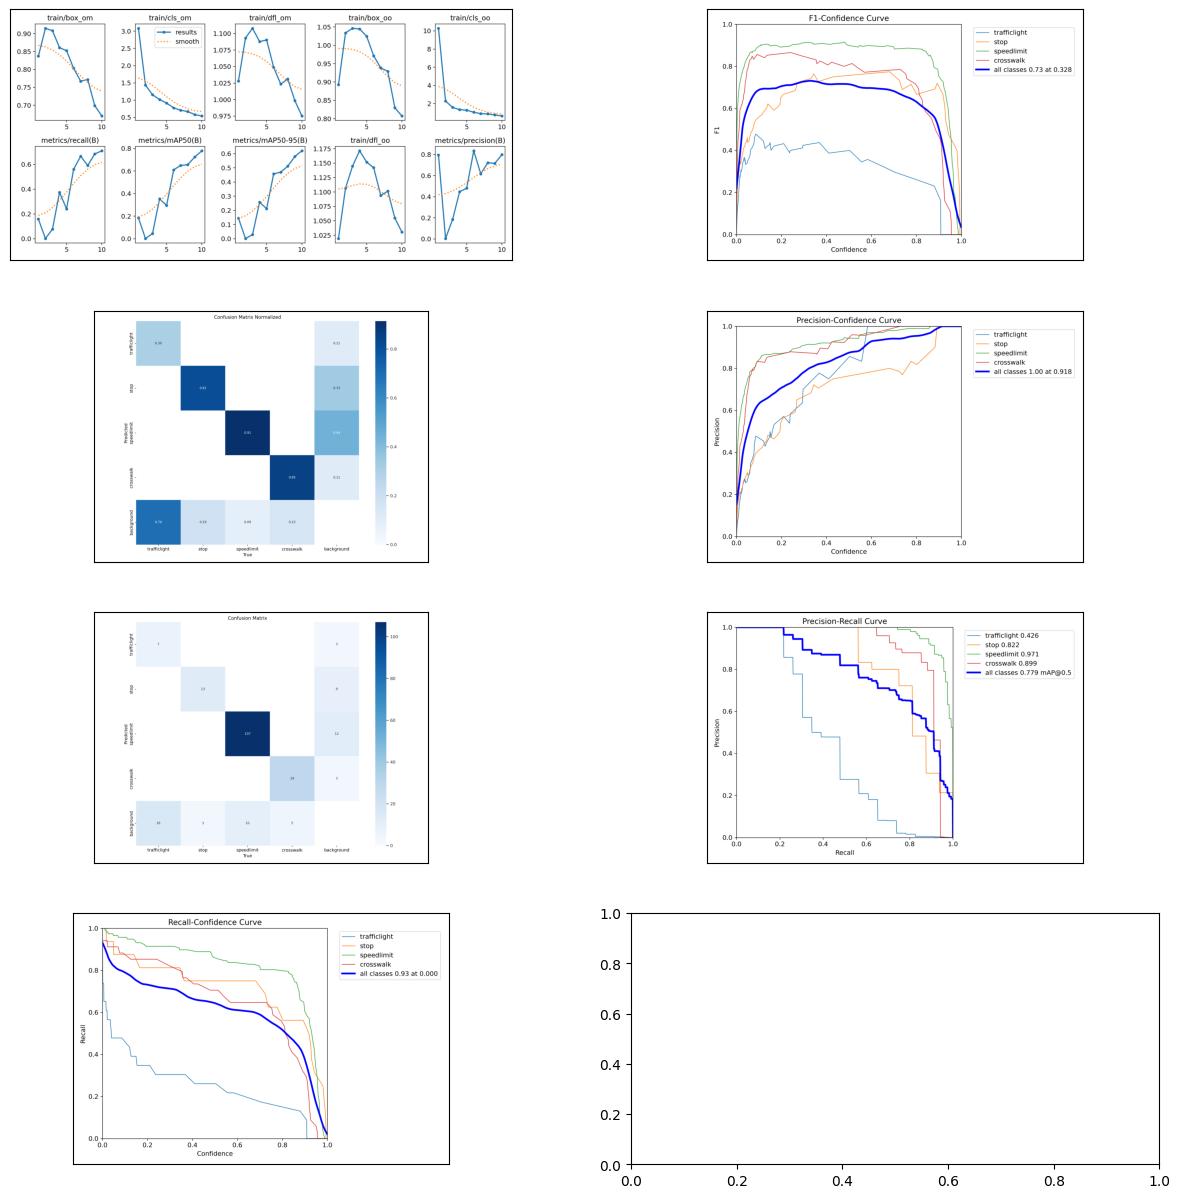

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from glob import glob
import matplotlib.ticker as ticker

metrics_img = glob(os.path.join(SAVE_PATH, 'train/*.png'))
n_img = len(metrics_img)
n_cols = 2
n_rows = int(n_img / n_cols) + (1 if n_img % n_cols != 0 else 0)
_, axs = plt.subplots(n_rows, n_cols, figsize=(15, 15))
axs = axs.flatten()
for m, ax in zip(metrics_img, axs):
  img = plt.imread(m)
  ax.imshow(img)
  ax.xaxis.set_major_locator(ticker.NullLocator())
  ax.yaxis.set_major_locator(ticker.NullLocator())
plt.show()

# Realizar inferência de métricas no conjunto de validação (val/valid)

In [ ]:
# Avaliar o modelo
model.val(save_json=True)

Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.0.1+cu117 CUDA:0 (Tesla T4, 15102MiB)
YOLOv10m summary (fused): 369 layers, 16455016 parameters, 0 gradients, 63.4 GFLOPs
val: Scanning /content/trafficsign/labels/val.cache... 132 images, 0 backgrounds, 0 corrupt: 100% 132/132 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 9/9 [00:05<00:00,  1.76it/s]
                   all        132        190      0.797      0.711       0.78      0.619
          trafficlight        132         23      0.722      0.304      0.428      0.245
                  stop        132         16      0.677      0.812      0.822      0.724
            speedlimit        132        117      0.915      0.914      0.971      0.846
             crosswalk        132         34      0.873      0.812      0.899      0.661
Speed: 0.8ms preprocess, 20.6ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /content/yolov10_run/val
💡 Learn more

# Visualização dos gráficos das métricas de validação

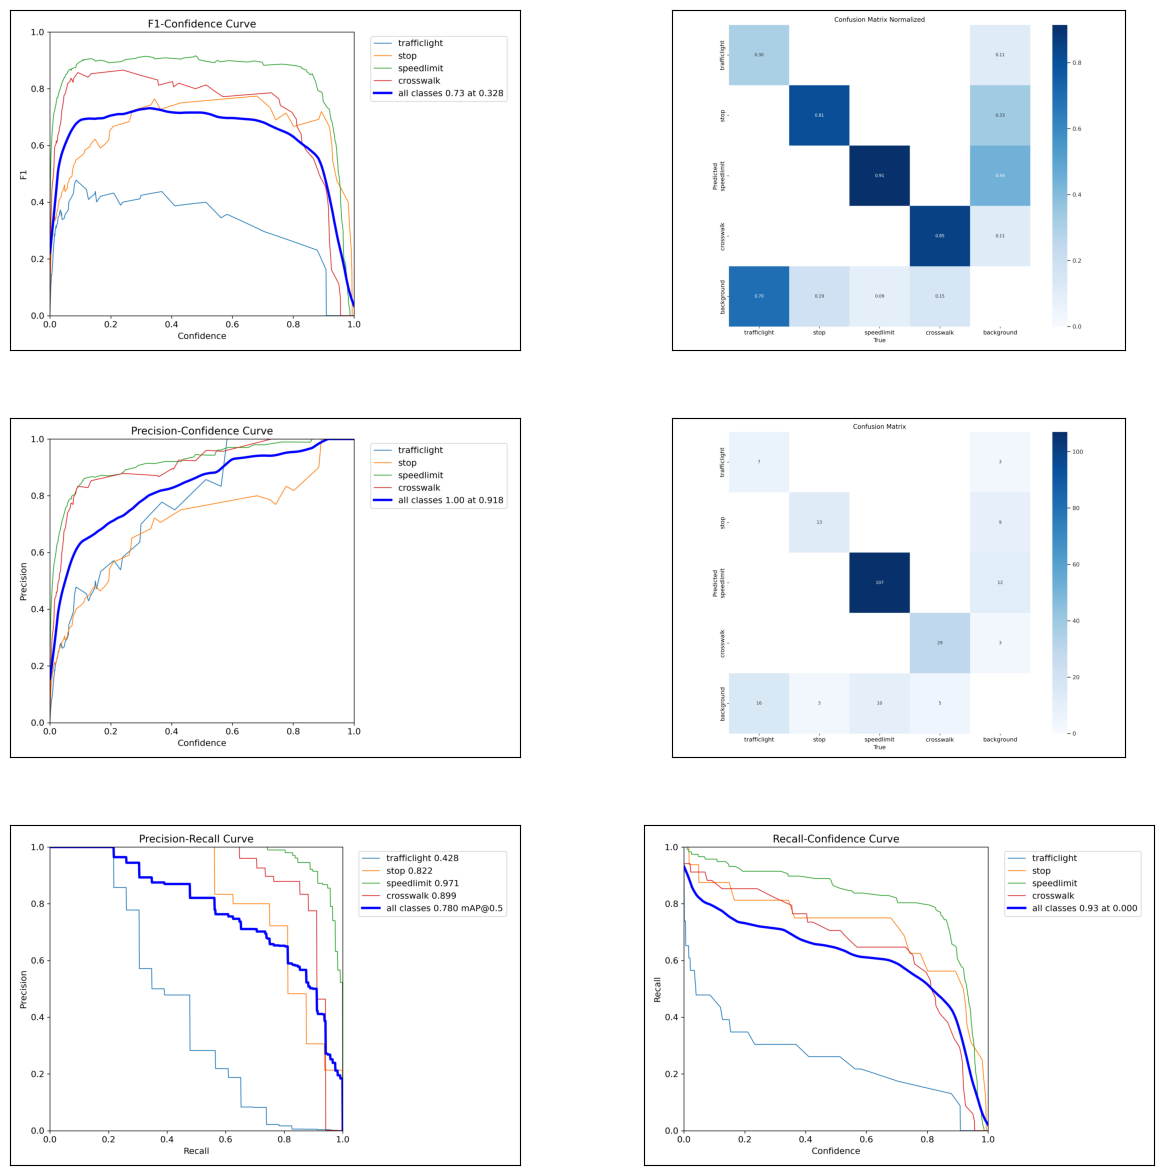

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from glob import glob
import matplotlib.ticker as ticker

metrics_img = glob(os.path.join(SAVE_PATH, "val/*.png"))
n_img = len(metrics_img)
n_cols = 2
n_rows = int(n_img / n_cols) + (1 if n_img % n_cols != 0 else 0)
_, axs = plt.subplots(n_rows, n_cols, figsize=(15, 15))
axs = axs.flatten()
for m, ax in zip(metrics_img, axs):
  img = plt.imread(m)
  ax.imshow(img)
  ax.xaxis.set_major_locator(ticker.NullLocator())
  ax.yaxis.set_major_locator(ticker.NullLocator())
plt.show()


# Visualizar detecções no conjunto de teste (test)

In [ ]:
model.predict(os.path.join(BASE_PATH, "/trafficsign/images/test"), save=True, conf=0.5)

Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.0.1+cu117 CUDA:0 (Tesla T4, 15102MiB)
YOLOv10m summary (fused): 369 layers, 16455016 parameters, 0 gradients, 63.4 GFLOPs

image 1/132 /content/trafficsign/images/test/road1.png: 480x640 (no detections), 170.6ms
image 2/132 /content/trafficsign/images/test/road108.png: 416x640 1 speedlimit, 105.4ms
image 3/132 /content/trafficsign/images/test/road115.png: 384x640 1 speedlimit, 121.6ms
image 4/132 /content/trafficsign/images/test/road12.png: 640x512 3 trafficlights, 113.0ms
image 5/132 /content/trafficsign/images/test/road125.png: 640x448 1 crosswalk, 116.1ms
image 6/132 /content/trafficsign/images/test/road131.png: 448x640 3 crosswalks, 103.4ms
image 7/132 /content/trafficsign/images/test/road132.png: 480x640 1 crosswalk, 30.5ms
image 8/132 /content/trafficsign/images/test/road144.png: 416x640 (no detections), 29.5ms
image 9/132 /content/trafficsign/images/test/road147.png: 384x640 2 crosswalks, 28.1ms
image 10/132 /content/trafficsign/i

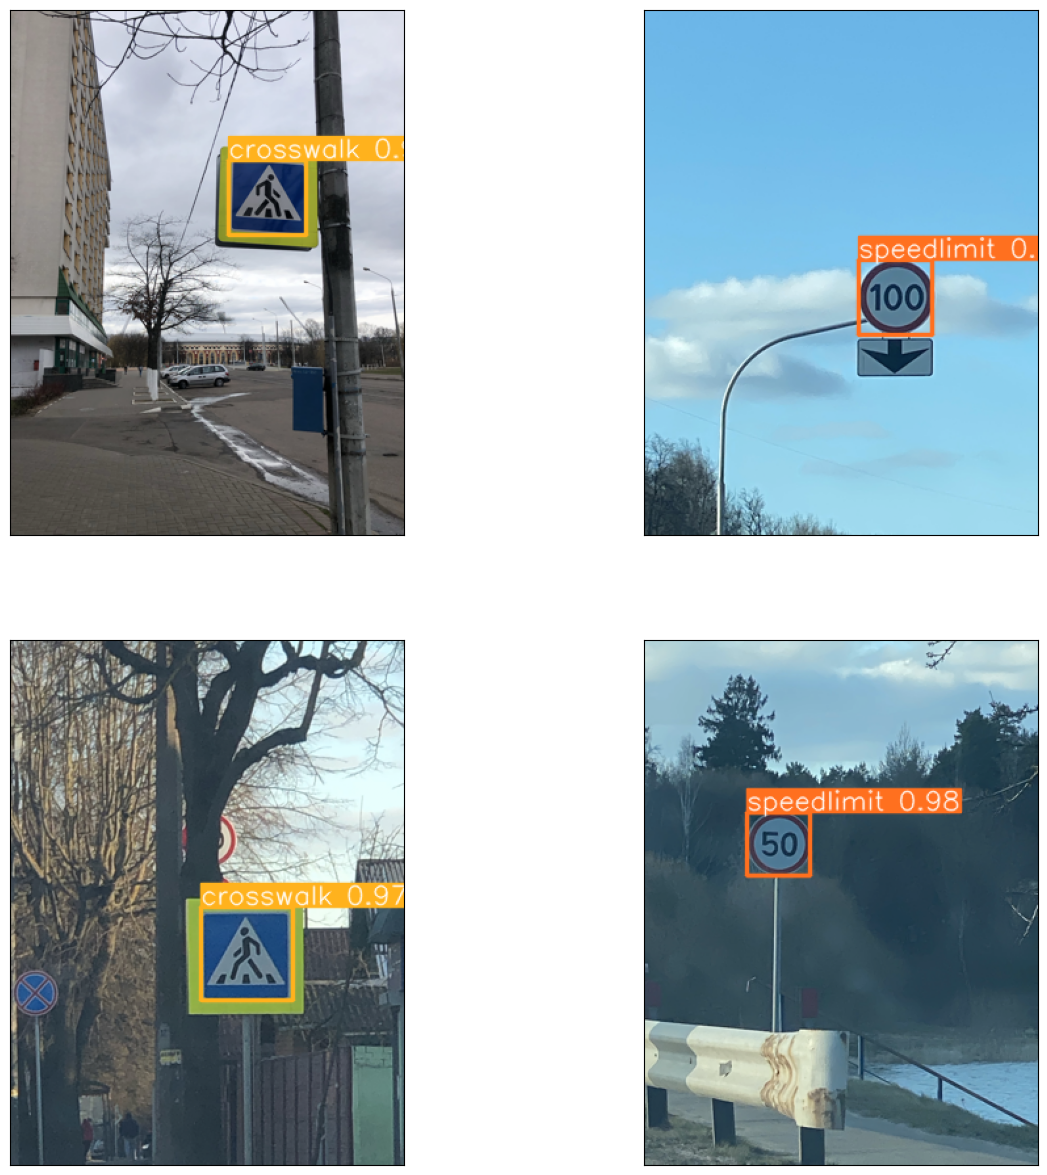

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
from glob import glob
import matplotlib.ticker as ticker
import random

num_samples = 4 # numero de imagens para visualizar.
all_dets = glob(os.path.join(SAVE_PATH, "detect/*.png"))
n_cols = 2
n_rows = int(num_samples / n_cols) + (1 if num_samples % n_cols != 0 else 0)
_, axs = plt.subplots(n_rows, n_cols, figsize=(15, 15))
axs = axs.flatten()
for m, ax in zip(random.sample(all_dets, num_samples), axs):
  img = plt.imread(m)
  ax.imshow(img)
  ax.xaxis.set_major_locator(ticker.NullLocator())
  ax.yaxis.set_major_locator(ticker.NullLocator())
plt.show()

In [ ]:
# realizar predict em uma imagem qualquer
model('https://ultralytics.com/images/bus.jpg')

<img src="http://lapix.ufsc.br/wp-content/uploads/2022/10/rodape-lapix.png">